## Track parameter and uncertainty estimation

In [ ]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers, optimizers
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

# Local imports
from drawing import draw_event, draw_input_and_pred

### Configuration

In [2]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)

# Track slopes are chosen by choosing a start and end point at random,
# where the end point lies on a plane some distance away (possibly behind the detector)
eff_depth = det_width

# Scale track slopes up so that slopes and intercepts receive equal weights in the loss function.
slope_scale = eff_depth/2

# Number of tracks in each event follows Poisson distribution
mean_tracks = 3
max_tracks = 6

### Functions for toy data generation

In [3]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        # Note: slopes are calculated assuming a square detector.
        # This prevents extremely large slope values in the non-square detector case
        ms = (b2s-bs)/eff_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        # append dummy values for covariance matrix entries
        # (these are predicted by the model but have no ground truth values)
        dummy_cov = np.zeros((batch_size))
        targets = zip(bs, ms, dummy_cov, dummy_cov, dummy_cov)
        for i, (b,m,_,_,_) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 5))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for training track prediction model
def gen_n_tracks_nocov(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = gen_single.next()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)[:,:2]
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

### Test the multi-track generator

[[  2.3601626    4.23082222]
 [ 23.2669101    6.15844608]
 [ 36.13497074  -5.27811729]]


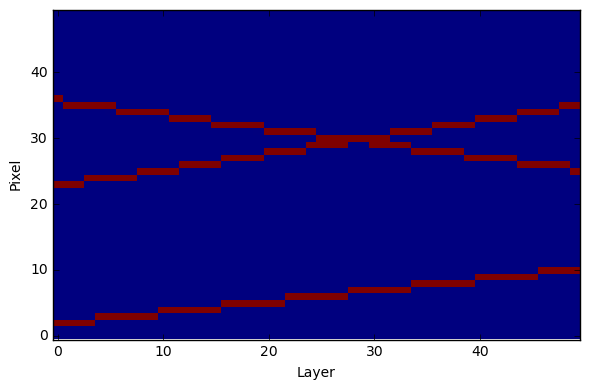

In [4]:
tracks, targets = gen_n_tracks_nocov().next()
draw_event(tracks[0,0])
print targets[0]

### Functions for visualizing track uncertainties

In [5]:
import gauss_likelihood_loss
import theano as th
import theano.tensor as T
from gauss_likelihood_loss import covariance_from_network_params, covariance_matrix_2D

in_params = T.vector()
out_params = covariance_matrix_2D( in_params )
covariance = th.function(inputs=[in_params], outputs=out_params)

def simulate_track_from_cov_matrix(track_params, cov_params, ntoys=1000):
    """Given the covariance matrix parameters, generate random track slope/intercept
        from the covariance matrix and draw the resulting track"""
    cov = covariance(cov_params)
    event = np.zeros(det_shape)
    toys = np.random.multivariate_normal(mean=track_params, cov=cov, size=ntoys)
    for i in range(ntoys):
        b, m = toys[i]
        event += simulate_straight_track(m/slope_scale, b, det_shape)
    return event

def simulate_event_from_cov_matrix(event_pred, ntoys=1000):
    return sum( [ simulate_track_from_cov_matrix(track_params=pred[:2], cov_params=pred[2:])
                       for pred in event_pred ] )

def make_pred_with_errors(model, n_tracks=mean_tracks):
    """Shows the model's uncertainty graphically for a random event"""
    test_data = gen_n_tracks(n_tracks=n_tracks).next()
    test_event = test_data[0][0]
    test_target = test_data[1][0]
    test_pred = model.predict(np.asarray([test_event]))[0]
    print test_target
    print test_pred
    pred_event = simulate_event_from_cov_matrix(test_pred, ntoys=10000)
    draw_input_and_pred(test_event[0], pred_event)
    
def make_pred_without_errors(model, n_tracks=mean_tracks):
    """Shows the tracks predicted by the model"""
    test_data = gen_n_tracks(n_tracks=n_tracks).next()
    test_event = test_data[0][0]
    test_target = test_data[1][0]
    test_pred = model.predict(np.asarray([test_event]))[0]
    print test_target
    print test_pred
    pred_event = np.clip(sum([ simulate_straight_track(
                    line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
    draw_input_and_pred(test_event[0], pred_event)

### Define model and train

In [9]:
class PretrainableModel(object):
    """Class representing our tracking convnet model outputting both 
       track parameters and covariance matrices. Capable of pretraining
       the track-finding part and freezing that part while training the covariance part.
       Attributes:
           n_tracks (int): number of tracks per event
           epoch_size (int): number of events to process per training epoch
           pretrain (bool): whether to pretrain track-finding part
           pretrain_layers (list of keras layers): layers to pretrain
           track_pred_model (keras model): model predicting track parameters
           full_model (keras model): full model, including covariance matrix predictor
           track_pred_gen, full_gen: generators yielding batches of training data
               for training track_pred_model and full_model, respectively
           """
    
    def __init__(self, n_tracks, pretrain=True, batch_size=batch_size, epoch_size=epoch_size):
        self.n_tracks = n_tracks
        self.epoch_size = epoch_size
        self.pretrain = pretrain
        self.track_pred_gen = gen_n_tracks_nocov(n_tracks=n_tracks, batch_size=batch_size)
        self.full_gen = gen_n_tracks(n_tracks=n_tracks, batch_size=batch_size)
        self.set_model()
        
    def set_model(self):
        pretrain_layers = []

        input_layer = layers.Input(shape=(1, det_depth, det_width))
        layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
        pretrain_layers.append(layer)
        layer = layers.Activation('relu')(layer)
        layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
        pretrain_layers.append(layer)
        layer = layers.Activation('relu')(layer)
        layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
        layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
        pretrain_layers.append(layer)
        layer = layers.Activation('relu')(layer)
        layer = layers.Convolution2D(32, 3, 3, border_mode='same')(layer)
        pretrain_layers.append(layer)
        layer = layers.Activation('relu')(layer)
        layer = layers.Flatten()(layer)
    
        layer_tracks = layers.Dense(400)(layer)
        pretrain_layers.append(layer_tracks)
        layer_tracks = layers.RepeatVector(self.n_tracks)(layer_tracks)
        layer_tracks = layers.LSTM(400, return_sequences=True)(layer_tracks)
        pretrain_layers.append(layer_tracks)
        output_layer_tracks = layers.TimeDistributed(layers.Dense(2))(layer_tracks) # track parameters
        pretrain_layers.append(output_layer_tracks)
        self.track_pred_model = models.Model(input=input_layer, output=output_layer_tracks)
        self.compile_track_pred_model()
    
        layer_cov = layers.Dense(400)(layer)
        layer_cov = layers.RepeatVector(self.n_tracks)(layer_cov)
        layer_cov = layers.LSTM(400, return_sequences=True)(layer_cov)
        layer_cov = layers.TimeDistributed(layers.Dense(3))(layer_cov) # track covariance matrix parameters
        output_layer_cov = layers.Lambda(gauss_likelihood_loss.covariance_from_network_outputs)(layer_cov)
    
        output_layer = layers.merge([output_layer_tracks, output_layer_cov], mode='concat', concat_axis=2)
        self.full_model = models.Model(input=input_layer, output=output_layer)
        
        self.pretrain_layers = pretrain_layers
        self.compile_full_model()
        
    def compile_track_pred_model(self):
        self.track_pred_model.compile(loss='mean_squared_error', optimizer='Adam')
        
    def compile_full_model(self):
        adam = optimizers.Adam(clipnorm=5)
        self.full_model.compile(loss=gauss_likelihood_loss.gauss_likelihood_loss_2D, optimizer=adam)
        
    def freeze_pretrain_layers(self, freeze=True):
        """If freeze=True, freeze weights on all pretrain layers.
           If freeze=False, unfreeze the weights.
           Important: the models need to be recompiled before this change will have any effect!"""
        for l in self.pretrain_layers:
            l.trainable = (not freeze)

    def train_track_pred_model(self, epochs=1):
        if self.pretrain: # if we don't pretrain the model, unfreezing layers is not necessary
            self.freeze_pretrain_layers(False)
        self.compile_track_pred_model()
        self.track_pred_model.fit_generator(self.track_pred_gen, self.epoch_size, epochs)
        
    def train_full_model(self, epochs=1):
        if self.pretrain:
            self.freeze_pretrain_layers()
        self.compile_full_model()
        self.full_model.fit_generator(self.full_gen, self.epoch_size, epochs)
        
    def make_pred_with_errors(self):
        make_pred_with_errors(self.full_model, n_tracks=self.n_tracks)
    
    def make_pred(self):
        make_pred_without_errors(self.full_model, n_tracks=self.n_tracks)

In [40]:
# Train the model
pretrainable_model_1 = PretrainableModel(n_tracks=1)
pretrainable_model_1.train_track_pred_model(epochs=5)

Epoch 1/5
256000/256000 [==============================] - 72s - loss: 34.9487    
Epoch 2/5
256000/256000 [==============================] - 69s - loss: 0.1939    
Epoch 3/5
256000/256000 [==============================] - 72s - loss: 0.0969    
Epoch 4/5
256000/256000 [==============================] - 71s - loss: 0.0191    
Epoch 5/5
256000/256000 [==============================] - 69s - loss: 0.0117    


In [46]:
pretrainable_model_1.train_full_model(epochs=6)

Epoch 1/6
256000/256000 [==============================] - 611s - loss: -906.0719   
Epoch 2/6
256000/256000 [==============================] - 615s - loss: -1853.0841   
Epoch 3/6
256000/256000 [==============================] - 589s - loss: -1985.9721   
Epoch 4/6
256000/256000 [==============================] - 607s - loss: -1891.6166   
Epoch 5/6
256000/256000 [==============================] - 617s - loss: -2128.7329   
Epoch 6/6
256000/256000 [==============================] - 613s - loss: -2165.2673   


[[ 46.37785406 -13.47151903   0.           0.           0.        ]]
[[  4.64130211e+01  -1.34327469e+01   4.27005906e-03  -3.31263221e-03
    3.82042490e-03]]


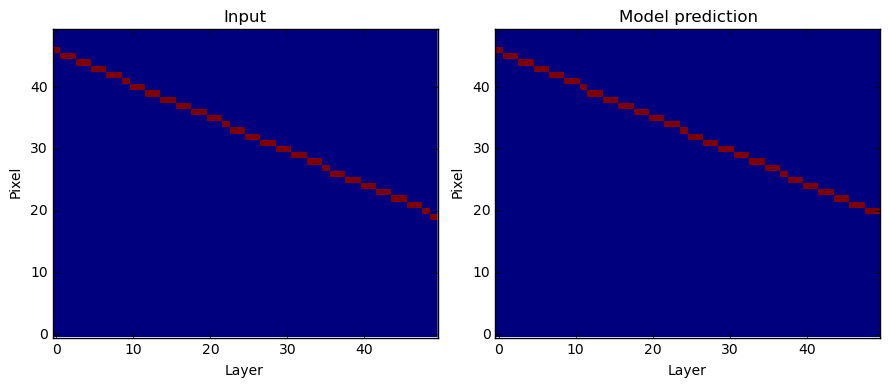

In [47]:
pretrainable_model_1.make_pred()

### Visualize predictions

[[ 24.04470714  -8.16953687   0.           0.           0.        ]]
[[  2.41088791e+01  -8.22758961e+00   3.77416098e-03  -2.79768952e-03
    3.18594323e-03]]


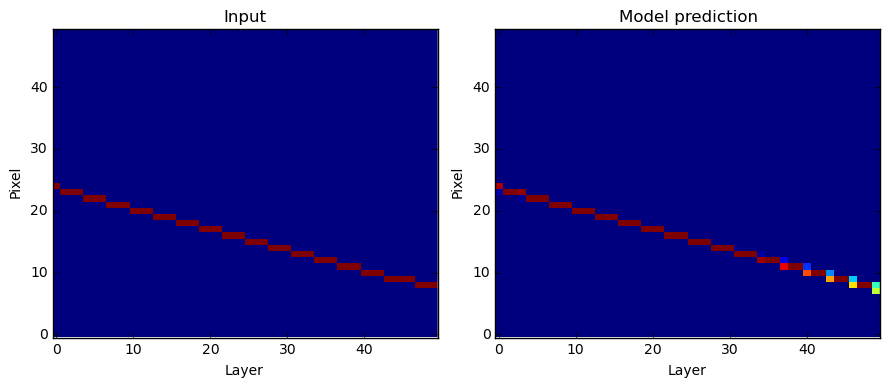

In [48]:
pretrainable_model_1.make_pred_with_errors()

### 6-track model

In [14]:
pretrainable_model_6 = PretrainableModel(n_tracks=6, epoch_size=25600)
pretrainable_model_6.train_track_pred_model(epochs=300)
pretrainable_model_6.train_full_model(epochs=100)

Epoch 1/300
25600/25600 [==============================] - 7s - loss: 107.1727     
Epoch 2/300
25600/25600 [==============================] - 7s - loss: 59.2158     
Epoch 3/300
25600/25600 [==============================] - 6s - loss: 40.3243     
Epoch 4/300
25600/25600 [==============================] - 6s - loss: 30.3664     
Epoch 5/300
25600/25600 [==============================] - 9s - loss: 24.8921     
Epoch 6/300
25600/25600 [==============================] - 6s - loss: 20.8359     
Epoch 7/300
25600/25600 [==============================] - 6s - loss: 18.0106     
Epoch 8/300
25600/25600 [==============================] - 7s - loss: 16.1285     
Epoch 9/300
25600/25600 [==============================] - 10s - loss: 13.9576    
Epoch 10/300
25600/25600 [==============================] - 6s - loss: 12.1160     
Epoch 11/300
25600/25600 [==============================] - 7s - loss: 10.6703     
Epoch 12/300
25600/25600 [==============================] - 11s - loss: 9.1287    
E

[[  7.99578585e+00   4.84953380e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.77512971e+01   1.28885841e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.60946325e+01   7.54231525e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.96383327e+01   4.04407812e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.17215259e+01  -9.89742835e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  4.00076412e+01  -1.04427664e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
[[  7.83810520e+00   4.98909330e+00   1.32803377e-02  -8.97545461e-03
    2.07893327e-02]
 [  1.76711426e+01   1.28382397e+01   1.89886652e-02  -1.79491322e-02
    6.08724393e-02]
 [  2.62030640e+01   7.63898277e+00   4.22620140e-02  -5.40880747e-02
    2.44417340e-01]
 [  2.94654140e+01   3.82491350e+00   9.52361599e-02  -1.35402098e-01
    7.08451211e-01]
 [  3.15415707e+01   4.52125221e-02   6.59932196e-02  -9.56547707e-02
    4.65127558e-01]
 [  4.014

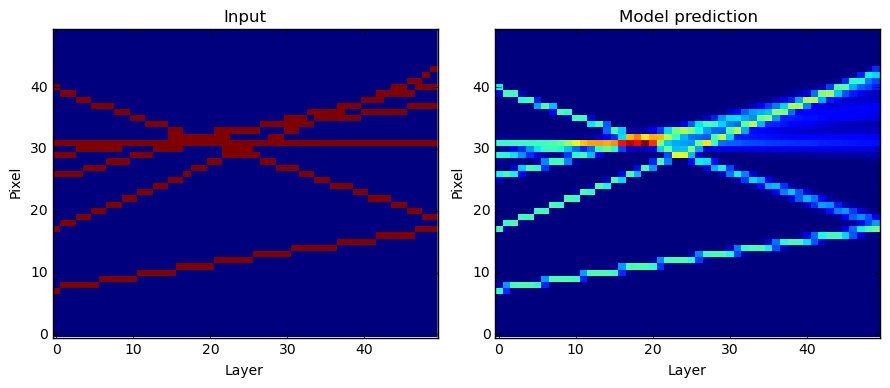

In [15]:
pretrainable_model_6.make_pred_with_errors()

[[ 15.53701706  13.8235559    0.           0.           0.        ]
 [ 21.703438    -0.75235304   0.           0.           0.        ]
 [ 23.30235925  -5.7089132    0.           0.           0.        ]
 [ 24.64185007  -9.05567258   0.           0.           0.        ]
 [ 39.49088874  -1.43672585   0.           0.           0.        ]
 [ 42.26178044  -2.05275178   0.           0.           0.        ]]
[[  1.55649586e+01   1.36954145e+01   2.65330803e-02  -3.18619013e-02
    1.54207528e-01]
 [  2.13293419e+01   3.17332625e-01   1.00490332e-01  -1.84897751e-01
    1.88541877e+00]
 [  2.32140102e+01  -5.82185125e+00   1.25361696e-01  -2.42748618e-01
    3.46973252e+00]
 [  2.46083775e+01  -9.05413628e+00   5.29945269e-02  -1.03500351e-01
    1.06334114e+00]
 [  3.95305595e+01  -1.31352079e+00   3.39424610e-02  -3.61889042e-02
    1.33645967e-01]
 [  4.22218437e+01  -2.09835386e+00   3.79520468e-02  -3.79338115e-02
    1.04643300e-01]]


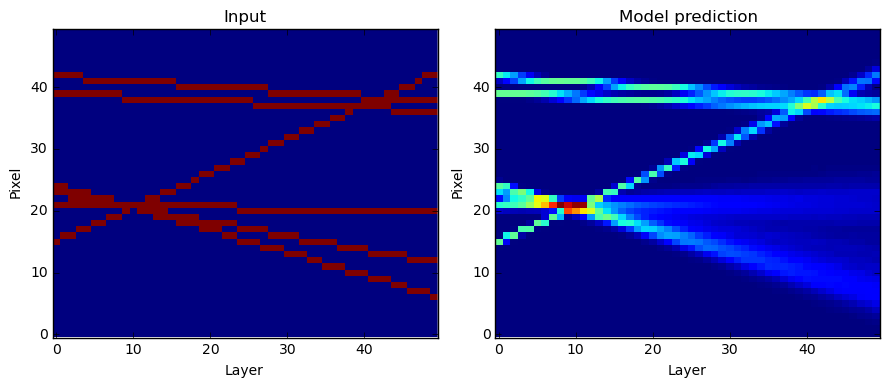

In [16]:
pretrainable_model_6.make_pred_with_errors()

[[  3.36816819  17.55222051   0.           0.           0.        ]
 [ 27.79602156   2.42302003   0.           0.           0.        ]
 [ 29.54016121   6.47119714   0.           0.           0.        ]
 [ 30.44027764  -7.72986829   0.           0.           0.        ]
 [ 39.04524899 -18.34752482   0.           0.           0.        ]
 [ 43.16083428  -3.54797504   0.           0.           0.        ]]
[[  3.39481544e+00   1.74655876e+01   1.67290103e-02  -1.17878821e-02
    2.63686422e-02]
 [  2.76170940e+01   3.36001968e+00   4.72270399e-02  -7.71090388e-02
    8.49246621e-01]
 [  2.97732754e+01   5.55097151e+00   8.97691250e-02  -5.25391884e-02
    6.84106970e+00]
 [  3.06244926e+01  -5.95552492e+00   5.36868125e-02  -3.74391563e-02
    4.36057997e+00]
 [  3.90887299e+01  -1.87109261e+01   2.84884572e-02  -2.69594546e-02
    1.21227488e-01]
 [  4.33097191e+01  -3.82364321e+00   2.37050038e-02  -1.94878224e-02
    5.16735949e-02]]


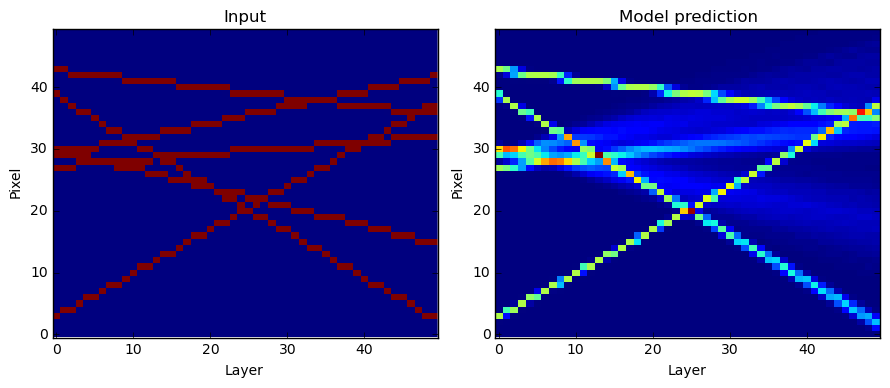

In [17]:
pretrainable_model_6.make_pred_with_errors()

[[  1.16682817   9.32028563   0.           0.           0.        ]
 [  8.27286295   4.26956262   0.           0.           0.        ]
 [ 42.4750735  -13.77388179   0.           0.           0.        ]
 [ 43.10868896 -19.01784156   0.           0.           0.        ]
 [ 45.95842682 -15.2686416    0.           0.           0.        ]
 [ 49.47487456  -6.55523714   0.           0.           0.        ]]
[[  1.31053030e+00   9.35537148e+00   1.43955834e-02  -1.07257571e-02
    2.55906042e-02]
 [  8.58230686e+00   3.94448161e+00   2.97256280e-02  -2.87050325e-02
    1.00242496e-01]
 [  4.23592033e+01  -1.34987183e+01   7.43192658e-02  -8.85168165e-02
    8.88004363e-01]
 [  4.31754532e+01  -1.89719124e+01   1.30283490e-01  -1.04692720e-01
    1.43087208e+00]
 [  4.57859230e+01  -1.47388878e+01   1.07166231e-01  -1.02571517e-01
    6.54356062e-01]
 [  4.94788017e+01  -6.37748289e+00   3.31878327e-02  -3.22033800e-02
    1.33138031e-01]]


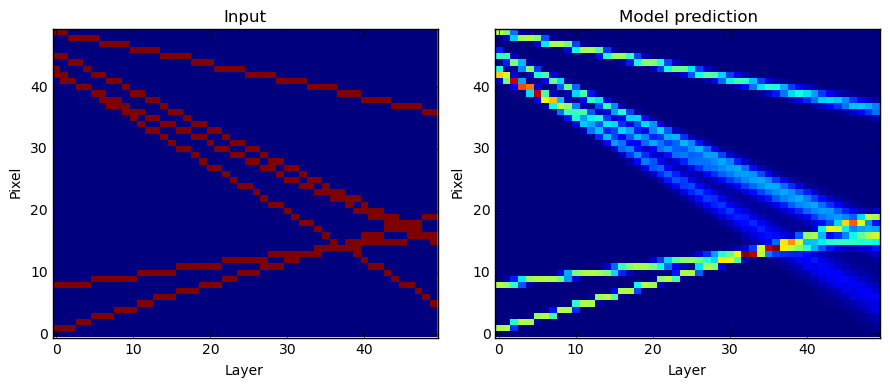

In [19]:
pretrainable_model_6.make_pred_with_errors()

### Visualize uncertainty distribution using a probability plot

In [22]:
import scipy.stats as stats
import pylab
import numpy.linalg

def squared_mahalanobis_distance(true, pred, cov):
    resid = pred-true
    # expand_dims is used to turn the row vector into a column vector
    precis_times_resid = np.matmul( np.linalg.inv(cov), np.expand_dims(resid, axis=-1) )
    return np.matmul( np.expand_dims(resid, axis=1), precis_times_resid )

def cov_from_params(params):
    """turns vector [variance1, covariance, variance2] into 2x2 covariance matrix"""
    return np.stack( [params, np.roll(params, shift=-1, axis=1)], axis=1 )[:,:,:2]

def sim_mahalanobis_distribution(model, ntoys=100, n_tracks=1):
    """Generates random events and computes the Mahalanobis distance for each.  
        Returns the list of all sampled M. distance values."""
    # for compatibility with PretrainableModel wrapper class
    if hasattr(model, "full_model"):
        n_tracks = model.n_tracks
        model = model.full_model
    gen = gen_n_tracks(n_tracks=n_tracks, batch_size=1)
    m = [] # simulated values of M. distance
    for _ in range(ntoys):
        test_data = gen.next()
        test_event = test_data[0][0]
        true = test_data[1][0,:,:2]
        test_pred = model.predict(np.asarray([test_event]))[0]
        pred = test_pred[:,:2]
        cov = cov_from_params( test_pred[:,2:] )
        m += squared_mahalanobis_distance(true, pred, cov).flatten().tolist()
    return m

def make_qq_plot(mahalanobis_vals):
    ref = range(0,15)
    stats.probplot(mahalanobis_vals, dist=stats.chi2, sparams=(2,), fit=False, plot=plt)
    plt.axis([0,10,0,10])
    plt.plot(ref, ref, 'k--')
    plt.show()

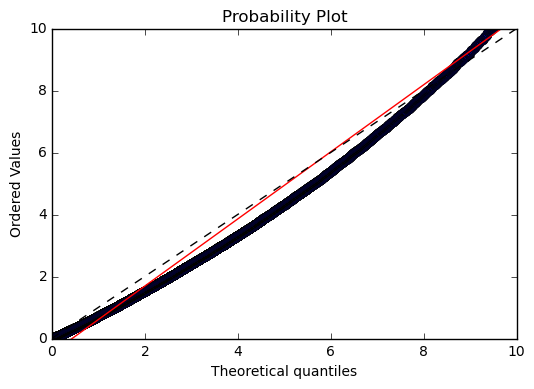

In [23]:
make_qq_plot( sim_mahalanobis_distribution(pretrainable_model_6, ntoys=10000) )